# Projeto Ray-Tracing (pt.1)

Libs utilizadas:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import os

# Esta lib é apenas para acompanhar o processamento
# ela mostrará a % do processo, melhorando a visibilidade
# do que está acontecendo no fundo

from tqdm import tqdm

### 1 Versão:

- [x] Câmera variando posição e orientação
- [x] Raios primários em perspectiva
- [x] Interseção raio-Esfera
- [x] Interseção raio-plano
- [x] Interseção raio-triangulo
- [x] Encontrar objeto mais a frente

Fazer aparecer apenas os contornos do objeto, sem _shading_.

Primeiro vamos as definições das formas geométricas:

In [3]:
class Triangulo:
    """Classe que representa um triângulo
    """

    def __init__(self, positions, color) -> None:
        self.positions = np.array(positions)
        self.cor = np.array(color)

    def intersect(self, ray_origin, ray_dir):
        """Calcula se há, e a interseção de um raio no triangulo

        fonte: https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-rendering-a-triangle/ray-triangle-intersection-geometric-solution

        Args:
            ray_origin (list): ponto de origem
            ray_dir (list): vetor de direção

        Returns:
            t: ponto onde o raio é intercectado
        """

        v0v1 = self.positions[1] - self.positions[0]
        v0v2 = self.positions[2] - self.positions[0]

        e = 10 ** (-6)  # constante para evitar erros de calculo

        n = np.cross(v0v1, v0v2)

        NdotRayDirection = np.dot(n, ray_dir)

        if abs(NdotRayDirection) < e:
            return

        d = -np.dot(n, self.positions[0])
        t = -(np.dot(n, ray_origin) + d) / NdotRayDirection

        if t < 0:
            return

        p = ray_origin + t * ray_dir

        # Testaremos cada uma das pontas

        edge0 = self.positions[1] - self.positions[0]
        vp0 = p - self.positions[0]
        c = np.cross(edge0, vp0)

        if np.dot(n, c) < 0:
            return

        edge1 = self.positions[2] - self.positions[1]
        vp1 = p - self.positions[1]
        c = np.cross(edge1, vp1)

        if np.dot(n, c) < 0:
            return

        edge2 = self.positions[0] - self.positions[2]
        vp2 = p - self.positions[2]
        c = np.cross(edge2, vp2)

        if np.dot(n, c) < 0:
            return
        else:
            return t

    def get_normal(self, point_on_object=None):
        print("normalizing triangle")
        a = self.positions[1] - self.positions[0]
        b = self.positions[2] - self.positions[1]
        normal = np.cross(a, b)
        norm = np.linalg.norm(normal)
        return normal / norm


In [4]:
class Plano:
    """Classe responsável por representar um Plano
    """

    def __init__(self, sample, normal, color) -> None:
        self.sample = np.array(sample)
        self.normal = np.array(normal)
        self.cor = color

    def intersect(self, ray_origin, ray_dir):
        """Retorna o ponto onde o ponto é intersectado

        fonte: https://www.scratchapixel.com/lessons/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-plane-and-ray-disk-intersection

        Args:
            ray_origin (list): ponto de origem
            ray_dir (list): vetor de direção

        Returns:
            t: ponto onde o raio é intercectado
        """
        t = math.inf
        den = np.inner(ray_dir, self.normal)

        e = 10 ** (-6)  # constante para evitar erros de calculo

        if abs(den) > e:
            t = np.inner((self.sample - ray_origin), self.normal) / den
            if t < 0:
                # Raio não intersecta o plano
                return
            else:
                return t
        else:
            # Inner product between ray_dir and normal_vector too low
            return

    def get_normal(self, point_on_object=None):
        """Retorna a normal normalizada

        Args:
            point_on_object (list, optional): ponto no objeto. Defaults to None.

        Returns:
            list: normal
        """
        norm = np.linalg.norm(self.normal)
        return self.normal / norm

In [5]:
class Esfera:
    def __init__(self, centro, raioCircuferencia, cor):
        self.centro = centro
        self.raioCircuferencia = raioCircuferencia
        self.cor = np.array(cor)

    def intersect(self, ray_origin, ray_dir):
        """
        fonte: https://www.scratchapixel.com/lessons/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-plane-and-ray-disk-intersection
        """
        
        l = self.centro - ray_origin
        t_ca = np.inner(l, ray_dir)

        inner = np.inner(l, l)

        d_2 = (inner) - (t_ca) ** 2

        if d_2 > (self.raioCircuferencia) ** 2:
            # Raio nao intersecta a esfera
            return
        else:
            t_hc = math.sqrt(self.raioCircuferencia ** 2 - d_2)
            t0 = t_ca - t_hc
            t1 = t_ca + t_hc
            if t0 > t1:
                t0, t1 = t1, t0
            if t0 < 0:
                if t1 < 0:
                    # Off-sColor_reen intersection with sphere
                    return None
                else:
                    return t1

            return t0

    def get_normal(self, point_on_object):
        center = self.centro
        center_to_point_vec = (point_on_object) - center
        norm = np.linalg.norm(center_to_point_vec)
        return center_to_point_vec / norm

Definimos então as entidades de Cena e motor gráfico (engine) responsáveis por armazenar as informações de ambiente:

In [6]:
# A classe cena possui todos os elementos recebidos a partir do JSON de leitura de cena
class Cena:
    def __init__(
        self,
        objetos,
        largura,
        altura,
        w,
        u,
        v,
        q00,
        vec_prod,
        tamanho_pixel,
        foco,
        distancia_focal,
    ):
        self.objetos = objetos
        self.largura = largura
        self.altura = altura
        self.w = w
        self.u = u
        self.v = v
        self.q00 = q00
        self.vec_prod = vec_prod
        self.tamanho_pixel = tamanho_pixel
        self.foco = foco
        self.distancia_focal = distancia_focal

In [7]:
# A classe RenderEngine é o motor de renderizamento do nosso projeto, aqui são feitos todos os calculos relacionados as imagens
class RenderEngine:
    def render(self, cena: Cena, background_color):
        # Criada uma imagem base totalmente preta (preenchida por RGB(0,0,0))
        image = np.zeros((cena.altura, cena.largura, 3), dtype=np.uint8)

        # Criacao da base ortonormal {u,v,w}
        w = cena.w
        u = cena.u
        v = cena.v

        # Lancamento dos raios
        q_00 = cena.q00

        # Passamos de pixel em pixel definindo a cor 
        for i in tqdm(range(cena.altura)):
            for j in range(cena.largura):
                q_ij = q_00 + cena.tamanho_pixel * (j * u - i * v)
                dir_ray = (q_ij - cena.foco) / np.linalg.norm(q_ij - cena.foco)
                image[i][j] = self.cast(cena, dir_ray, background_color)
        return image

    def trace(self, E, dir_ray, cena):
        s = []
        for obj in cena.objetos:
            t = obj.intersect(E, dir_ray)
            if t:
                s.append((t, obj))
        return s

    # Ray-Casting
    def cast(self, cena, dir_ray, background_color):
        E = cena.foco
        c = background_color
        S = self.trace(E, dir_ray, cena)

        if S:
            closest_t = math.inf
            closest_obj = None

            for t_obj in S:
                if t_obj[0] < closest_t:
                    closest_t = t_obj[0]
                    closest_obj = t_obj[1]
                    c = closest_obj.cor
        return c


Com essa estrutura, conseguimos fazer todo o processamento necessário para a primeira versão do projeto

Agora faremos a leitura da cena e calculos necessários:

In [8]:
def read_objects(cena):

    objetos = []

    # iterar sobre os objetos da cena, criando cada um deles
    # usando as classes por nós definidas
    for element in cena["objects"]:
        keys = list(element.keys())

        if "sphere" in keys:
            form = "sphere"
        elif "plane" in keys:
            form = "plane"
        elif "triangle" in keys:
            form = "triangle"

        props = element[form]

        # Criamos baseado no nome dentro do objeto json

        if form == "sphere":
            obj = Esfera(np.array(props["center"]), props["radius"], np.array(element["color"]),)

        elif form == "plane":
            obj = Plano(
                np.array(props["sample"]), np.array(props["normal"]), np.array(element["color"]),
            )

        elif form == "triangle":
            obj = Triangulo(np.array(props), element["color"])

        objetos.append(obj)

    return objetos


In [9]:
def build_scene(objetos, cena):

    # Constantes tiradas a partir do JSON

    altura = cena.get("v_res", 0)
    largura = cena.get("h_res", 0)
    distancia = cena.get("dist", 0)
    tamanho_pixel = cena.get("square_side", 0)
    bc = cena.get("background_color", 0)
    up = np.array(cena.get("up", 0))
    foco = np.array(cena.get("eye", 0))
    distancia_focal = np.array(cena.get("look_at", 0))

    # Instância da classe Cor, pra facilitar integração com outros arquivos
    background_color = np.array(bc)

    # Constantes - aqui começa o processamento e a aplicação de funções de PG

    w = (foco - distancia_focal) / np.linalg.norm(foco - distancia_focal)
    vec_prod = np.cross(up, w)

    u = (vec_prod) / (np.linalg.norm(vec_prod))
    v = np.cross(w, u)

    q00 = (
        foco
        - distancia * w
        + tamanho_pixel * (((altura - 1) / 2) * v - ((largura - 1) / 2) * u)
    )

    # Montar a Cena
    cena = Cena(
        objetos,
        largura,
        altura,
        w,
        u,
        v,
        q00,
        vec_prod,
        tamanho_pixel,
        foco,
        distancia_focal,
    )

    return cena, background_color



In [16]:
def read_files(scene_name: str):
    cenas = []

    path = 'RayTracing1/primeira_versao/objetos/'

    # Leitura do arquivo scene_name dentro do caminho

    for filename in os.listdir(path):
        if filename == scene_name:
            f = os.path.join(path, filename)
            if os.path.isfile(f):
                file = open(f)
                text = json.load(file)
                cenas.append(text)
                file.close()

    # Pegamos apenas a cena lida primeiro (caso de nomes duplicados)
    cena = cenas[0]

    return cena


Função para automatizar o processo de leitura:

In [17]:
def start_loading(filename: str):
    contexto = read_files(filename)
    objetos = read_objects(contexto)

    scene, background_color = build_scene(objetos, contexto)

    engine = RenderEngine()
    imagem = engine.render(scene, background_color)

    plt.imshow(imagem)
    plt.show()

Próxima célula irá executar o render de todas as cenas dentro do diretorio `primeira_versao/objetos` em ordem de complexidade, da mais rápida pra mais demorada.

100%|██████████| 480/480 [00:05<00:00, 86.27it/s]


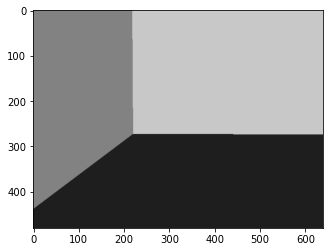

100%|██████████| 480/480 [00:03<00:00, 127.73it/s]


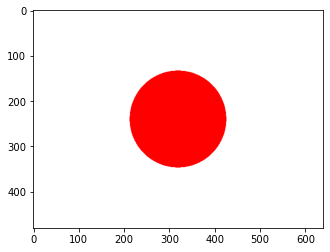

100%|██████████| 480/480 [00:05<00:00, 88.53it/s]


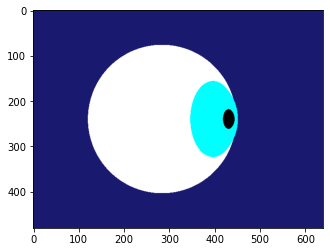

100%|██████████| 480/480 [00:03<00:00, 126.26it/s]


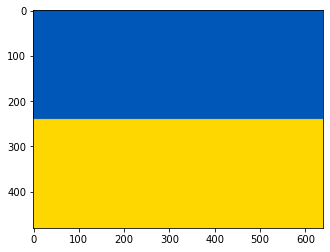

 14%|█▍        | 67/480 [00:43<04:29,  1.53it/s]


KeyboardInterrupt: 

In [20]:
# files = ['cone.json']

files = ['canto.json', 'japao.json', 'olho.json', 'ucrania.json', 'cone.json']

# Os objetos 'suzanne.json', 'icosaedro.json' levariam mais de 20h de processamento se somados
# Isso inviabiliza o plot pois eu uso o computador para trabalho e outras atividades
# Se houver uma máquina com maior processamento, podem utilizá-la para o plot

# Leitura do arquivo scene_name dentro do caminho

for filename in files:
        start_loading(filename)

Aqui fica a entrada, o monitor pode ficar livre para abrir o diretório "primeira_versao/objetos" e utilizar o nome de qualquer json como input da função **start_loading**

In [ ]:
file = input("Digite o nome do arquivo sem o .json no final")
start_loading(f"{file}.json")